In [5]:
import os
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

BASE_DIR = "."
OUTPUT_DIR = os.path.join(BASE_DIR, "processed")

# Load the file you saved earlier
img_features_path = os.path.join(OUTPUT_DIR, "image_features.csv")
img_df = pd.read_csv(img_features_path)

print(img_df.shape)
img_df.head()

(14652, 28)


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed,image_path,img_brightness,img_colorfulness,img_blur
0,2,Nibble,3,299,0,1,1,7,0,1,...,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2,./train_images/86e1089a3-1.jpg,95.860984,16.616995,672.776551
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0,./train_images/6296e909a-1.jpg,88.262347,50.059973,453.839186
2,1,Brisco,1,307,0,1,2,7,0,2,...,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3,./train_images/3422e4906-1.jpg,170.645100,11.606312,60.519822
3,1,Miko,4,307,0,2,1,2,0,2,...,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2,./train_images/5842f1ff5-1.jpg,78.406617,76.517158,512.140914
4,1,Hunter,1,307,0,1,1,0,0,2,...,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2,./train_images/850a43f90-1.jpg,165.758596,47.471541,363.798839


In [6]:
if "resolved_image_path" in img_df.columns:
    img_df["final_image_path"] = img_df["resolved_image_path"]
else:
    img_df["final_image_path"] = img_df["image_path"]

# Drop any rows where path is missing just to be safe
img_df = img_df[img_df["final_image_path"].notnull()].reset_index(drop=True)
len(img_df)

14652

In [7]:
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input

IMG_SIZE = (224, 224)
BATCH_SIZE = 32 

base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    pooling="avg",
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)

base_model.trainable = False  # we are only extracting features
base_model.summary()

2025-12-05 17:09:32.953704: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-05 17:09:32.953801: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2025-12-05 17:09:32.953832: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2025-12-05 17:09:32.953912: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-05 17:09:32.953947: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [8]:
from tensorflow.keras.utils import load_img, img_to_array

def load_and_preprocess_image(path: str):
    """
    Load an image from disk, resize to IMG_SIZE, convert to array, and return float32 tensor.
    """
    img = load_img(path, target_size=IMG_SIZE)
    arr = img_to_array(img)   # shape (H, W, 3)
    return arr  # we'll preprocess in batch

In [9]:
paths = img_df["final_image_path"].tolist()
n_images = len(paths)
print("Number of images to embed:", n_images)

# Run once to see embedding dimension
dummy = np.zeros((1, IMG_SIZE[0], IMG_SIZE[1], 3), dtype="float32")
dummy = preprocess_input(dummy)
dummy_emb = base_model.predict(dummy, verbose=0)
embedding_dim = dummy_emb.shape[1]
embedding_dim

Number of images to embed: 14652


2025-12-05 17:10:09.898459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1280

In [10]:
embeddings = np.zeros((n_images, embedding_dim), dtype="float32")

for start in tqdm(range(0, n_images, BATCH_SIZE), desc="Extracting CNN embeddings"):
    end = min(start + BATCH_SIZE, n_images)
    batch_paths = paths[start:end]

    batch_images = np.zeros((len(batch_paths), IMG_SIZE[0], IMG_SIZE[1], 3), dtype="float32")

    for i, p in enumerate(batch_paths):
        arr = load_and_preprocess_image(p)
        batch_images[i] = arr

    batch_images = preprocess_input(batch_images)
    batch_emb = base_model.predict(batch_images, verbose=0)

    embeddings[start:end] = batch_emb

embeddings.shape

Extracting CNN embeddings: 100%|██████████████| 458/458 [01:23<00:00,  5.48it/s]


(14652, 1280)

In [1]:
# Ensure processed directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

embeddings_path = os.path.join(OUTPUT_DIR, "image_embeddings_efficientnet_b0.npy")
np.save(embeddings_path, embeddings)
print("Saved embeddings to:", embeddings_path)

# Mapping: which row corresponds to which pet
embedding_index_df = img_df[["PetID", "final_image_path"]].copy()
embedding_index_df["embedding_index"] = np.arange(len(img_df))

embedding_index_path = os.path.join(OUTPUT_DIR, "image_embedding_index.csv")
embedding_index_df.to_csv(embedding_index_path, index=False)
print("Saved embedding index to:", embedding_index_path)

NameError: name 'os' is not defined

In [12]:
print("Embeddings shape:", embeddings.shape)
print("First vector (first 10 dims):", embeddings[0][:10])

Embeddings shape: (14652, 1280)
First vector (first 10 dims): [ 0.25331515 -0.14703286 -0.15937841 -0.06334338  0.08851725  0.03591205
  0.2803251   0.27920568  0.18864448  0.05540646]


## Step 6 — Build the image-only modeling dataset

In [13]:
import os
import numpy as np
import pandas as pd

BASE_DIR = "."
OUTPUT_DIR = os.path.join(BASE_DIR, "processed")

# 1) Load embeddings
embeddings_path = os.path.join(OUTPUT_DIR, "image_embeddings_efficientnet_b0.npy")
embeddings = np.load(embeddings_path)
print("Embeddings shape:", embeddings.shape)

# 2) Load embedding index mapping
embedding_index_path = os.path.join(OUTPUT_DIR, "image_embedding_index.csv")
embed_idx_df = pd.read_csv(embedding_index_path)
print(embed_idx_df.head())

# 3) Load image_features.csv (has PetID + AdoptionSpeed)
img_features_path = os.path.join(OUTPUT_DIR, "image_features.csv")
img_df = pd.read_csv(img_features_path)
print(img_df[["PetID", "AdoptionSpeed"]].head())

Embeddings shape: (14652, 1280)
       PetID                final_image_path  embedding_index
0  86e1089a3  ./train_images/86e1089a3-1.jpg                0
1  6296e909a  ./train_images/6296e909a-1.jpg                1
2  3422e4906  ./train_images/3422e4906-1.jpg                2
3  5842f1ff5  ./train_images/5842f1ff5-1.jpg                3
4  850a43f90  ./train_images/850a43f90-1.jpg                4
       PetID  AdoptionSpeed
0  86e1089a3              2
1  6296e909a              0
2  3422e4906              3
3  5842f1ff5              2
4  850a43f90              2


In [14]:
# Make sure PetID is same type
embed_idx_df["PetID"] = embed_idx_df["PetID"].astype(str)
img_df["PetID"] = img_df["PetID"].astype(str)

# Merge to get AdoptionSpeed along with embedding_index
image_model_df = embed_idx_df.merge(
    img_df[["PetID", "AdoptionSpeed"]],
    on="PetID",
    how="inner"
)

print(image_model_df.head())
print(image_model_df.shape)

       PetID                final_image_path  embedding_index  AdoptionSpeed
0  86e1089a3  ./train_images/86e1089a3-1.jpg                0              2
1  6296e909a  ./train_images/6296e909a-1.jpg                1              0
2  3422e4906  ./train_images/3422e4906-1.jpg                2              3
3  5842f1ff5  ./train_images/5842f1ff5-1.jpg                3              2
4  850a43f90  ./train_images/850a43f90-1.jpg                4              2
(14652, 4)


In [15]:
# X_img: select rows of embeddings in the same order as image_model_df
idx = image_model_df["embedding_index"].values
X_img = embeddings[idx]

# Target
y = image_model_df["AdoptionSpeed"].values

print("X_img shape:", X_img.shape)
print("y shape:", y.shape)
print("AdoptionSpeed distribution:", pd.Series(y).value_counts())

X_img shape: (14652, 1280)
y shape: (14652,)
AdoptionSpeed distribution: 2    4001
4    3984
3    3225
1    3056
0     386
Name: count, dtype: int64


At this point, you have a clean image-only modeling dataset:

- Each row = 1 pet

- Features = EfficientNet embedding (and later you could append brightness/blur/colorfulness)

- Target = AdoptionSpeed

## Step 7 — Train a baseline image-only model (with metrics)

Let’s start with something simple and solid: Logistic Regression on the embeddings, using 5-fold stratified CV with the metrics we discussed (Accuracy, Macro F1, QWK).

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score

scaler = StandardScaler()
X_img_scaled = scaler.fit_transform(X_img)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []
qwk_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_img_scaled, y)):
    print(f"---- Fold {fold+1} ----")
    
    X_tr, X_val = X_img_scaled[train_idx], X_img_scaled[val_idx]
    y_tr, y_val = y[train_idx], y[val_idx]
    
    model = LogisticRegression(
        multi_class="multinomial",
        solver="lbfgs",
        max_iter=1000,
        n_jobs=-1
    )
    
    model.fit(X_tr, y_tr)
    preds = model.predict(X_val)
    
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="macro")
    qwk = cohen_kappa_score(y_val, preds, weights="quadratic")
    
    acc_scores.append(acc)
    f1_scores.append(f1)
    qwk_scores.append(qwk)
    
    print(f"Fold {fold+1} - Acc: {acc:.3f}, Macro F1: {f1:.3f}, QWK: {qwk:.3f}")

print("\n=== Image-only Logistic Regression on Embeddings ===")
print(f"Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
print(f"Macro F1: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"QWK:      {np.mean(qwk_scores):.3f} ± {np.std(qwk_scores):.3f}")

---- Fold 1 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 1 - Acc: 0.297, Macro F1: 0.252, QWK: 0.195
---- Fold 2 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 2 - Acc: 0.313, Macro F1: 0.268, QWK: 0.229
---- Fold 3 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 3 - Acc: 0.303, Macro F1: 0.250, QWK: 0.188
---- Fold 4 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 4 - Acc: 0.301, Macro F1: 0.261, QWK: 0.201
---- Fold 5 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 5 - Acc: 0.319, Macro F1: 0.268, QWK: 0.236

=== Image-only Logistic Regression on Embeddings ===
Accuracy: 0.307 ± 0.008
Macro F1: 0.260 ± 0.008
QWK:      0.210 ± 0.019


This gives you:

A first benchmark for “image-only” performance

Something directly comparable later to:

- tabular-only model

- text-only model

- full multimodal fusion

## Step 8 — Try a tree model on embeddings (Random Forest / XGBoost)

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=42
)

acc_scores = []
f1_scores = []
qwk_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_img, y)):
    print(f"---- RF Fold {fold+1} ----")
    
    X_tr, X_val = X_img[train_idx], X_img[val_idx]  # no scaling needed for RF
    y_tr, y_val = y[train_idx], y[val_idx]
    
    rf.fit(X_tr, y_tr)
    preds = rf.predict(X_val)
    
    acc = accuracy_score(y_val, preds)
    f1 = f1_score(y_val, preds, average="macro")
    qwk = cohen_kappa_score(y_val, preds, weights="quadratic")
    
    acc_scores.append(acc)
    f1_scores.append(f1)
    qwk_scores.append(qwk)

print("\n=== Image-only Random Forest on Embeddings ===")
print(f"Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
print(f"Macro F1: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
print(f"QWK:      {np.mean(qwk_scores):.3f} ± {np.std(qwk_scores):.3f}")

---- RF Fold 1 ----
---- RF Fold 2 ----
---- RF Fold 3 ----
---- RF Fold 4 ----
---- RF Fold 5 ----

=== Image-only Random Forest on Embeddings ===
Accuracy: 0.354 ± 0.007
Macro F1: 0.250 ± 0.007
QWK:      0.279 ± 0.016


In [18]:
pip install xgboost lightgbm catboost

  Using cached graphviz-0.21-py3-none-any.whl.metadata (12 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 29.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 38.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.8/27.8 MB 55.9 MB/s  0:00:00 eta 0:00:01
Using cached graphviz-0.21-py3-none-any.whl (47 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 53.1 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [catboost]5/6 [catboost]
Note: you may need to restart the kernel to use updated packages.


In [19]:
import os
import numpy as np
import pandas as pd

BASE_DIR = "."
OUTPUT_DIR = os.path.join(BASE_DIR, "processed")

# Load embeddings
embeddings = np.load(os.path.join(OUTPUT_DIR, "image_embeddings_efficientnet_b0.npy"))

# Load mapping
embed_idx_df = pd.read_csv(os.path.join(OUTPUT_DIR, "image_embedding_index.csv"))

# Load pet labels
img_df = pd.read_csv(os.path.join(OUTPUT_DIR, "image_features.csv"))
embed_idx_df["PetID"] = embed_idx_df["PetID"].astype(str)
img_df["PetID"] = img_df["PetID"].astype(str)

image_model_df = embed_idx_df.merge(img_df[["PetID", "AdoptionSpeed"]],
                                    on="PetID", how="inner")

idx = image_model_df["embedding_index"].values
X_img = embeddings[idx]
y = image_model_df["AdoptionSpeed"].values

print("X_img:", X_img.shape)
print("y:", y.shape)

X_img: (14652, 1280)
y: (14652,)


## STEP 3 — Utility: evaluation function

In [21]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
import numpy as np

def evaluate_model_cv(model, X, y, model_name="Model"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc_scores, f1_scores, qwk_scores = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"---- {model_name} | Fold {fold+1} ----")

        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        acc = accuracy_score(y_val, preds)
        f1 = f1_score(y_val, preds, average="macro")
        qwk = cohen_kappa_score(y_val, preds, weights="quadratic")

        acc_scores.append(acc)
        f1_scores.append(f1)
        qwk_scores.append(qwk)

        print(f"Acc={acc:.3f}, F1={f1:.3f}, QWK={qwk:.3f}")

    print("\n===== FINAL RESULTS:", model_name, "=====")
    print(f"Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
    print(f"Macro F1: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
    print(f"QWK:      {np.mean(qwk_scores):.3f} ± {np.std(qwk_scores):.3f}")

    return {
        "acc": np.mean(acc_scores),
        "f1": np.mean(f1_scores),
        "qwk": np.mean(qwk_scores)
    }


## STEP 4 — XGBoost on Embeddings

In [24]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist", # fast on CPU
    random_state=42
)

xgb_results = evaluate_model_cv(xgb_model, X_img, y, model_name="XGBoost (Embeddings)")

---- XGBoost (Embeddings) | Fold 1 ----
Acc=0.351, F1=0.263, QWK=0.261
---- XGBoost (Embeddings) | Fold 2 ----
Acc=0.361, F1=0.273, QWK=0.304
---- XGBoost (Embeddings) | Fold 3 ----
Acc=0.369, F1=0.275, QWK=0.286
---- XGBoost (Embeddings) | Fold 4 ----
Acc=0.358, F1=0.270, QWK=0.284
---- XGBoost (Embeddings) | Fold 5 ----
Acc=0.369, F1=0.279, QWK=0.288

===== FINAL RESULTS: XGBoost (Embeddings) =====
Accuracy: 0.362 ± 0.007
Macro F1: 0.272 ± 0.005
QWK:      0.284 ± 0.014


## STEP 5 — LightGBM on Embeddings

In [25]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=5,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_results = evaluate_model_cv(lgb_model, X_img, y, model_name="LightGBM (Embeddings)")

---- LightGBM (Embeddings) | Fold 1 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 11721, number of used features: 1280
[LightGBM] [Info] Start training from score -3.635796
[LightGBM] [Info] Start training from score -1.567337
[LightGBM] [Info] Start training from score -1.298231
[LightGBM] [Info] Start training from score -1.513593
[LightGBM] [Info] Start training from score -1.302302


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.356, F1=0.271, QWK=0.259
---- LightGBM (Embeddings) | Fold 2 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 11721, number of used features: 1280
[LightGBM] [Info] Start training from score -3.639038
[LightGBM] [Info] Start training from score -1.567337
[LightGBM] [Info] Start training from score -1.297919
[LightGBM] [Info] Start training from score -1.513593
[LightGBM] [Info] Start training from score -1.302302


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.353, F1=0.269, QWK=0.266
---- LightGBM (Embeddings) | Fold 3 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 11722, number of used features: 1280
[LightGBM] [Info] Start training from score -3.635881
[LightGBM] [Info] Start training from score -1.567831
[LightGBM] [Info] Start training from score -1.298004
[LightGBM] [Info] Start training from score -1.513678
[LightGBM] [Info] Start training from score -1.302074


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.353, F1=0.265, QWK=0.261
---- LightGBM (Embeddings) | Fold 4 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 11722, number of used features: 1280
[LightGBM] [Info] Start training from score -3.635881
[LightGBM] [Info] Start training from score -1.567422
[LightGBM] [Info] Start training from score -1.298004
[LightGBM] [Info] Start training from score -1.513678
[LightGBM] [Info] Start training from score -1.302387


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.341, F1=0.256, QWK=0.267
---- LightGBM (Embeddings) | Fold 5 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326400
[LightGBM] [Info] Number of data points in the train set: 11722, number of used features: 1280
[LightGBM] [Info] Start training from score -3.635881
[LightGBM] [Info] Start training from score -1.567422
[LightGBM] [Info] Start training from score -1.298004
[LightGBM] [Info] Start training from score -1.513678
[LightGBM] [Info] Start training from score -1.302387
Acc=0.357, F1=0.276, QWK=0.288

===== FINAL RESULTS: LightGBM (Embeddings) =====
Accuracy: 0.352 ± 0.006
Macro F1: 0.268 ± 0.007
QWK:      0.268 ± 0.010


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


## STEP 6 — CatBoost on Embeddings

In [26]:
from catboost import CatBoostClassifier

cb_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    verbose=False,
    random_seed=42
)

cb_results = evaluate_model_cv(cb_model, X_img, y, model_name="CatBoost (Embeddings)")

---- CatBoost (Embeddings) | Fold 1 ----
Acc=0.355, F1=0.256, QWK=0.271
---- CatBoost (Embeddings) | Fold 2 ----
Acc=0.353, F1=0.249, QWK=0.284
---- CatBoost (Embeddings) | Fold 3 ----
Acc=0.362, F1=0.258, QWK=0.280
---- CatBoost (Embeddings) | Fold 4 ----
Acc=0.344, F1=0.245, QWK=0.266
---- CatBoost (Embeddings) | Fold 5 ----
Acc=0.369, F1=0.260, QWK=0.299

===== FINAL RESULTS: CatBoost (Embeddings) =====
Accuracy: 0.357 ± 0.008
Macro F1: 0.254 ± 0.006
QWK:      0.280 ± 0.011


## STEP 7 - Compare Results

In [27]:
results = {
    "XGBoost": xgb_results,
    "LightGBM": lgb_results,
    "CatBoost": cb_results
}

results

{'XGBoost': {'acc': 0.36158962159241625,
  'f1': 0.27203241011873197,
  'qwk': 0.28447238182117074},
 'LightGBM': {'acc': 0.35196523452373885,
  'f1': 0.267653753699518,
  'qwk': 0.26832836869561894},
 'CatBoost': {'acc': 0.35674343809786635,
  'f1': 0.25379404775651415,
  'qwk': 0.28006672713518077}}

# EMBEDDINGS + IMAGE FEATURES

In [29]:
import os
import numpy as np
import pandas as pd

BASE_DIR = "."
OUTPUT_DIR = os.path.join(BASE_DIR, "processed")

# 1) Load embeddings
embeddings = np.load(os.path.join(OUTPUT_DIR, "image_embeddings_efficientnet_b0.npy"))

# 2) Load index mapping
embed_idx_df = pd.read_csv(os.path.join(OUTPUT_DIR, "image_embedding_index.csv"))

# 3) Load image features (with brightness / colorfulness / blur)
img_df = pd.read_csv(os.path.join(OUTPUT_DIR, "image_features.csv"))

# Ensure PetID types align
embed_idx_df["PetID"] = embed_idx_df["PetID"].astype(str)
img_df["PetID"] = img_df["PetID"].astype(str)

# Join to get AdoptionSpeed + image quality features + embedding_index
image_model_df = embed_idx_df.merge(
    img_df[["PetID", "AdoptionSpeed", "img_brightness", "img_colorfulness", "img_blur"]],
    on="PetID",
    how="inner"
)

print(image_model_df.head())
print(image_model_df.shape)

       PetID                final_image_path  embedding_index  AdoptionSpeed  \
0  86e1089a3  ./train_images/86e1089a3-1.jpg                0              2   
1  6296e909a  ./train_images/6296e909a-1.jpg                1              0   
2  3422e4906  ./train_images/3422e4906-1.jpg                2              3   
3  5842f1ff5  ./train_images/5842f1ff5-1.jpg                3              2   
4  850a43f90  ./train_images/850a43f90-1.jpg                4              2   

   img_brightness  img_colorfulness    img_blur  
0       95.860984         16.616995  672.776551  
1       88.262347         50.059973  453.839186  
2      170.645100         11.606312   60.519822  
3       78.406617         76.517158  512.140914  
4      165.758596         47.471541  363.798839  
(14652, 7)


In [30]:
idx = image_model_df["embedding_index"].values
X_img = embeddings[idx]              # (N, embedding_dim)
y = image_model_df["AdoptionSpeed"].values

print("X_img shape:", X_img.shape)
print("y shape:", y.shape)

X_img shape: (14652, 1280)
y shape: (14652,)


In [31]:
# Get quality features in the SAME order as image_model_df
img_quality = image_model_df[["img_brightness", "img_colorfulness", "img_blur"]].values

print("img_quality shape:", img_quality.shape)  # (N, 3)

# Concatenate along feature dimension
X_img_aug = np.concatenate([X_img, img_quality], axis=1)
print("X_img_aug shape:", X_img_aug.shape)  # (N, embedding_dim + 3)

img_quality shape: (14652, 3)
X_img_aug shape: (14652, 1283)


In [32]:
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

def evaluate_model_cv(model, X, y, model_name="Model"):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    acc_scores, f1_scores, qwk_scores = [], [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"---- {model_name} | Fold {fold+1} ----")

        X_tr, X_val = X[train_idx], X[val_idx]
        y_tr, y_val = y[train_idx], y[val_idx]

        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)

        acc = accuracy_score(y_val, preds)
        f1 = f1_score(y_val, preds, average="macro")
        qwk = cohen_kappa_score(y_val, preds, weights="quadratic")

        acc_scores.append(acc)
        f1_scores.append(f1)
        qwk_scores.append(qwk)

        print(f"Acc={acc:.3f}, F1={f1:.3f}, QWK={qwk:.3f}")

    print("\n===== FINAL RESULTS:", model_name, "=====")
    print(f"Accuracy: {np.mean(acc_scores):.3f} ± {np.std(acc_scores):.3f}")
    print(f"Macro F1: {np.mean(f1_scores):.3f} ± {np.std(f1_scores):.3f}")
    print(f"QWK:      {np.mean(qwk_scores):.3f} ± {np.std(qwk_scores):.3f}")

    return {
        "acc": float(np.mean(acc_scores)),
        "f1": float(np.mean(f1_scores)),
        "qwk": float(np.mean(qwk_scores))
    }

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
X_img_aug_scaled = scaler.fit_transform(X_img_aug)

lr_aug = LogisticRegression(
    multi_class="multinomial",
    solver="lbfgs",
    max_iter=1000,
    n_jobs=-1
)

lr_aug_results = evaluate_model_cv(lr_aug, X_img_aug_scaled, y,
                                   model_name="LogReg (Embeddings + Quality)")

---- LogReg (Embeddings + Quality) | Fold 1 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acc=0.300, F1=0.255, QWK=0.190
---- LogReg (Embeddings + Quality) | Fold 2 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acc=0.312, F1=0.264, QWK=0.235
---- LogReg (Embeddings + Quality) | Fold 3 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acc=0.304, F1=0.249, QWK=0.186
---- LogReg (Embeddings + Quality) | Fold 4 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acc=0.302, F1=0.262, QWK=0.209
---- LogReg (Embeddings + Quality) | Fold 5 ----


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Acc=0.314, F1=0.264, QWK=0.226

===== FINAL RESULTS: LogReg (Embeddings + Quality) =====
Accuracy: 0.306 ± 0.006
Macro F1: 0.259 ± 0.006
QWK:      0.209 ± 0.019


In [34]:
import lightgbm as lgb
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# XGBoost
xgb_aug = XGBClassifier(
    objective="multi:softmax",
    num_class=5,
    eval_metric="mlogloss",
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist",
    random_state=42
)

# LightGBM
lgb_aug = lgb.LGBMClassifier(
    objective="multiclass",
    num_class=5,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# CatBoost
cb_aug = CatBoostClassifier(
    iterations=300,
    learning_rate=0.05,
    depth=6,
    loss_function='MultiClass',
    verbose=False,
    random_seed=42
)

xgb_aug_results = evaluate_model_cv(xgb_aug, X_img_aug, y,
                                    model_name="XGBoost (Embeddings + Quality)")

lgb_aug_results = evaluate_model_cv(lgb_aug, X_img_aug, y,
                                    model_name="LightGBM (Embeddings + Quality)")

cb_aug_results = evaluate_model_cv(cb_aug, X_img_aug, y,
                                   model_name="CatBoost (Embeddings + Quality)")

---- XGBoost (Embeddings + Quality) | Fold 1 ----
Acc=0.347, F1=0.261, QWK=0.256
---- XGBoost (Embeddings + Quality) | Fold 2 ----
Acc=0.356, F1=0.270, QWK=0.281
---- XGBoost (Embeddings + Quality) | Fold 3 ----
Acc=0.360, F1=0.270, QWK=0.295
---- XGBoost (Embeddings + Quality) | Fold 4 ----
Acc=0.343, F1=0.255, QWK=0.278
---- XGBoost (Embeddings + Quality) | Fold 5 ----
Acc=0.366, F1=0.278, QWK=0.292

===== FINAL RESULTS: XGBoost (Embeddings + Quality) =====
Accuracy: 0.354 ± 0.008
Macro F1: 0.267 ± 0.008
QWK:      0.280 ± 0.014
---- LightGBM (Embeddings + Quality) | Fold 1 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327165
[LightGBM] [Info] Number of data points in the train set: 11721, number of used features: 1283
[LightGBM] [Info] Start training from score -3.635796
[LightGBM] [Info] Start training from score -1.567337
[LightGBM] [

/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.347, F1=0.263, QWK=0.252
---- LightGBM (Embeddings + Quality) | Fold 2 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027395 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327165
[LightGBM] [Info] Number of data points in the train set: 11721, number of used features: 1283
[LightGBM] [Info] Start training from score -3.639038
[LightGBM] [Info] Start training from score -1.567337
[LightGBM] [Info] Start training from score -1.297919
[LightGBM] [Info] Start training from score -1.513593
[LightGBM] [Info] Start training from score -1.302302


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.352, F1=0.269, QWK=0.271
---- LightGBM (Embeddings + Quality) | Fold 3 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327165
[LightGBM] [Info] Number of data points in the train set: 11722, number of used features: 1283
[LightGBM] [Info] Start training from score -3.635881
[LightGBM] [Info] Start training from score -1.567831
[LightGBM] [Info] Start training from score -1.298004
[LightGBM] [Info] Start training from score -1.513678
[LightGBM] [Info] Start training from score -1.302074


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.358, F1=0.267, QWK=0.276
---- LightGBM (Embeddings + Quality) | Fold 4 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327165
[LightGBM] [Info] Number of data points in the train set: 11722, number of used features: 1283
[LightGBM] [Info] Start training from score -3.635881
[LightGBM] [Info] Start training from score -1.567422
[LightGBM] [Info] Start training from score -1.298004
[LightGBM] [Info] Start training from score -1.513678
[LightGBM] [Info] Start training from score -1.302387


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.352, F1=0.266, QWK=0.278
---- LightGBM (Embeddings + Quality) | Fold 5 ----
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327165
[LightGBM] [Info] Number of data points in the train set: 11722, number of used features: 1283
[LightGBM] [Info] Start training from score -3.635881
[LightGBM] [Info] Start training from score -1.567422
[LightGBM] [Info] Start training from score -1.298004
[LightGBM] [Info] Start training from score -1.513678
[LightGBM] [Info] Start training from score -1.302387


/opt/anaconda3/envs/mihirtf/lib/python3.9/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Acc=0.358, F1=0.277, QWK=0.285

===== FINAL RESULTS: LightGBM (Embeddings + Quality) =====
Accuracy: 0.353 ± 0.004
Macro F1: 0.269 ± 0.005
QWK:      0.273 ± 0.011
---- CatBoost (Embeddings + Quality) | Fold 1 ----
Acc=0.349, F1=0.248, QWK=0.263
---- CatBoost (Embeddings + Quality) | Fold 2 ----
Acc=0.362, F1=0.259, QWK=0.290
---- CatBoost (Embeddings + Quality) | Fold 3 ----
Acc=0.360, F1=0.258, QWK=0.266
---- CatBoost (Embeddings + Quality) | Fold 4 ----
Acc=0.353, F1=0.252, QWK=0.283
---- CatBoost (Embeddings + Quality) | Fold 5 ----
Acc=0.362, F1=0.257, QWK=0.298

===== FINAL RESULTS: CatBoost (Embeddings + Quality) =====
Accuracy: 0.357 ± 0.005
Macro F1: 0.255 ± 0.004
QWK:      0.280 ± 0.014


In [36]:
np.save(os.path.join(OUTPUT_DIR, "X_img_embeddings.npy"), X_img)
np.save(os.path.join(OUTPUT_DIR, "X_img_embeddings_aug.npy"), X_img_aug)
np.save(os.path.join(OUTPUT_DIR, "y_adoption_speed.npy"), y)

# PHASE 1 = “Kaggle metadata analysis”

In [45]:
import os
import json
import pandas as pd
import numpy as np

BASE_DIR = "."  # or wherever your data is
TRAIN_CSV = os.path.join(BASE_DIR, "train.csv")
TRAIN_META_DIR = os.path.join(BASE_DIR, "train_metadata")  # folder with *.json

train_df = pd.read_csv(TRAIN_CSV)
train_df["PetID"] = train_df["PetID"].astype(str)

print(train_df.shape)
train_df.head()

(14993, 24)


,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,Health,Quantity,Fee,State,RescuerID,VideoAmt,Description,PetID,PhotoAmt,AdoptionSpeed
0,2,Nibble,3,299,0,1,1,7,0,1,...,1,1,100,41326,8480853f516546f6cf33aa88cd76c379,0,Nibble is a 3+ month old ball of cuteness. He ...,86e1089a3,1.0,2
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,1,1,0,41401,3082c7125d8fb66f7dd4bff4192c8b14,0,I just found it alone yesterday near my apartm...,6296e909a,2.0,0
2,1,Brisco,1,307,0,1,2,7,0,2,...,1,1,0,41326,fa90fa5b1ee11c86938398b60abc32cb,0,Their pregnant mother was dumped by her irresp...,3422e4906,7.0,3
3,1,Miko,4,307,0,2,1,2,0,2,...,1,1,150,41401,9238e4f44c71a75282e62f7136c6b240,0,"Good guard dog, very alert, active, obedience ...",5842f1ff5,8.0,2
4,1,Hunter,1,307,0,1,1,0,0,2,...,1,1,0,41326,95481e953f8aed9ec3d16fc4509537e8,0,This handsome yet cute boy is up for adoption....,850a43f90,3.0,2


In [49]:
def get_pet_id_from_filename(path):
    """
    Extract PetID from filename like 'abc123-1.json' -> 'abc123'
    """
    base = os.path.basename(path)
    pet_id = base.split("-")[0]  # 'abc123-1.json' -> 'abc123'
    return pet_id


def load_single_meta_entry(path):
    """
    Load a json file and return a single metadata dict.
    Handles cases where the JSON is a dict or a list of dicts.
    """
    with open(path, "r") as f:
        data = json.load(f)
    if isinstance(data, list) and len(data) > 0:
        return data[0]
    return data


def extract_label_list(entry, score_thresh=0.7):
    labels = []
    for ann in entry.get("labelAnnotations", []):
        if ann.get("score", 0) >= score_thresh:
            desc = ann.get("description", "").lower()
            if desc:
                labels.append(desc)
    return labels


def extract_object_list(entry, score_thresh=0.7):
    """
    In your sample JSON there is no localizedObjectAnnotations,
    so this will often return [].
    Keeping it for future-proofing.
    """
    objs = []
    for ann in entry.get("localizedObjectAnnotations", []):
        if ann.get("score", 0) >= score_thresh:
            name = ann.get("name", "").lower()
            if name:
                objs.append(name)
    return objs


def extract_pet_bbox_ratio(entry):
    """
    Compute max bounding box area ratio from localizedObjectAnnotations.
    Prefer objects named like dog/cat/puppy/kitten, else largest object.
    Returns a value between 0 and 1 (approx), or np.nan if none.
    """
    objs = entry.get("localizedObjectAnnotations", [])
    if not objs:
        return np.nan
    
    # Prefer pet-like objects
    pet_names = ("dog", "cat", "puppy", "kitten", "mammal", "pet")
    pet_objs = [o for o in objs if o.get("name", "").lower() in pet_names]
    target_objs = pet_objs if pet_objs else objs
    
    max_area = 0.0
    for o in target_objs:
        box = o.get("boundingPoly", {}).get("normalizedVertices", [])
        if len(box) < 4:
            continue
        
        xs = [v.get("x", 0.0) for v in box]
        ys = [v.get("y", 0.0) for v in box]
        width = max(xs) - min(xs)
        height = max(ys) - min(ys)
        area = max(width, 0.0) * max(height, 0.0)
        if area > max_area:
            max_area = area
    
    if max_area == 0.0:
        return np.nan
    return max_area

## NEW FUNCTIONS -

def extract_pet_bbox_ratio_from_crop(entry):
    """
    Approximate bounding box area ratio from cropHintsAnnotation.
    We only see pixel coordinates, not normalized ones.
    We approximate full image size using max x, y from the crop hint.
    This is a heuristic but still gives a relative measure.
    Returns np.nan if not available.
    """
    crop_ann = entry.get("cropHintsAnnotation", {})
    hints = crop_ann.get("cropHints", [])
    if not hints:
        return np.nan
    
    # Take the first crop hint
    box = hints[0].get("boundingPoly", {}).get("vertices", [])
    if len(box) < 4:
        return np.nan
    
    xs = [v.get("x", 0) for v in box]
    ys = [v.get("y", 0) for v in box]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    
    box_width = max_x - min_x
    box_height = max_y - min_y
    if box_width <= 0 or box_height <= 0:
        return np.nan
    
    # Approximate full image width/height as the max coords in this box
    full_w = max_x
    full_h = max_y
    if full_w <= 0 or full_h <= 0:
        return np.nan
    
    box_area = box_width * box_height
    full_area = full_w * full_h
    return box_area / full_area if full_area > 0 else np.nan

def extract_color_features(entry, top_k=5):
    """
    Extract simple color stats from dominantColors:
    - mean R, G, B
    - weighted by 'pixelFraction' if available, else 'score'
    """
    colors_info = (
        entry
        .get("imagePropertiesAnnotation", {})
        .get("dominantColors", {})
        .get("colors", [])
    )
    if not colors_info:
        return {
            "meta_mean_red": np.nan,
            "meta_mean_green": np.nan,
            "meta_mean_blue": np.nan,
        }

    reds, greens, blues, weights = [], [], [], []
    for c in colors_info[:top_k]:  # just use top K dominant colors
        color = c.get("color", {})
        r = color.get("red", 0)
        g = color.get("green", 0)
        b = color.get("blue", 0)
        w = c.get("pixelFraction", c.get("score", 1.0))

        reds.append(r)
        greens.append(g)
        blues.append(b)
        weights.append(w)

    weights = np.array(weights, dtype=float)
    weights = weights / (weights.sum() + 1e-8)

    mean_r = float(np.sum(np.array(reds) * weights))
    mean_g = float(np.sum(np.array(greens) * weights))
    mean_b = float(np.sum(np.array(blues) * weights))

    return {
        "meta_mean_red": mean_r,
        "meta_mean_green": mean_g,
        "meta_mean_blue": mean_b,
    }

# Keywords for simple interpretable flags
LABEL_KEYWORDS = {
    "outdoor": ["outdoor", "yard", "park", "grass", "field"],
    "indoor": ["indoor", "floor", "room", "living room"],
    "cage": ["cage", "crate", "kennel"],
    "sofa": ["sofa", "couch"],
    "person": ["person", "people", "man", "woman", "girl", "boy"],
    "leash": ["leash", "lead"],
}

def make_flag_dict(labels, objects):
    all_terms = set(labels) | set(objects)
    joined = " ".join(all_terms).lower()
    flags = {}
    for flag_name, keywords in LABEL_KEYWORDS.items():
        flags[f"has_{flag_name}"] = any(kw in joined for kw in keywords)
    return flags

In [50]:
from glob import glob

json_paths = glob(os.path.join(TRAIN_META_DIR, "*.json"))
print("Number of metadata json files:", len(json_paths))

rows = []

for path in json_paths:
    entry = load_single_meta_entry(path)  # from previous code
    pet_id = get_pet_id_from_filename(path)

    labels = extract_label_list(entry)
    objects = extract_object_list(entry)
    bbox_ratio = extract_pet_bbox_ratio_from_crop(entry)
    color_feats = extract_color_features(entry)
    flags = make_flag_dict(labels, objects)

    row = {
        "PetID": pet_id,
        "meta_num_labels": len(labels),
        "meta_num_objects": len(objects),
        "meta_pet_bbox_ratio": bbox_ratio,
        "meta_labels_raw": ";".join(labels),
        "meta_objects_raw": ";".join(objects),
    }
    row.update(color_feats)
    row.update(flags)
    rows.append(row)

meta_img_df = pd.DataFrame(rows)
meta_img_df["PetID"] = meta_img_df["PetID"].astype(str)

print(meta_img_df.shape)
meta_img_df.head()

Number of metadata json files: 58311
(58311, 15)


,PetID,meta_num_labels,meta_num_objects,meta_pet_bbox_ratio,meta_labels_raw,meta_objects_raw,meta_mean_red,meta_mean_green,meta_mean_blue,has_outdoor,has_indoor,has_cage,has_sofa,has_person,has_leash
0,bc5058e64,0,0,1.000000,,,110.397054,109.116823,104.111361,False,False,False,False,False,False
1,6afe7ee11,3,0,0.907919,fauna;tail;dog breed group,,150.581980,100.268792,67.152273,False,False,False,False,False,False
2,093cce3a1,6,0,1.000000,dog;dog like mammal;dog breed;dog breed group;...,,132.452460,125.326172,121.932128,False,False,False,False,False,False
3,ee5ceb065,6,0,1.000000,dog;dog breed;street dog;dog breed group;dog l...,,168.770720,138.214795,123.158591,False,False,False,False,False,False
4,8a4c95abd,7,0,1.000000,cat;siberian husky;small to medium sized cats;...,,219.890974,216.784613,168.664344,False,False,False,False,False,False


In [51]:
# Numeric aggregations
numeric_cols = ["meta_num_labels", "meta_num_objects", "meta_pet_bbox_ratio"]
num_agg = meta_img_df.groupby("PetID")[numeric_cols].agg(["mean", "max"])
num_agg.columns = [f"{c}_{stat}" for c, stat in num_agg.columns]  # flatten MultiIndex
num_agg = num_agg.reset_index()

# Boolean flags aggregations
flag_cols = [c for c in meta_img_df.columns if c.startswith("has_")]
flag_agg = meta_img_df.groupby("PetID")[flag_cols].max().reset_index()

# Merge numeric + flags
meta_pet_df = num_agg.merge(flag_agg, on="PetID", how="left")

print(meta_pet_df.shape)
meta_pet_df.head()

(14652, 13)


,PetID,meta_num_labels_mean,meta_num_labels_max,meta_num_objects_mean,meta_num_objects_max,meta_pet_bbox_ratio_mean,meta_pet_bbox_ratio_max,has_outdoor,has_indoor,has_cage,has_sofa,has_person,has_leash
0,0008c5398,6.500000,10,0.0,0,1.0,1.0,False,False,False,False,True,False
1,000a290e4,5.000000,6,0.0,0,1.0,1.0,False,False,False,False,False,False
2,000fb9572,5.333333,7,0.0,0,1.0,1.0,False,False,True,False,False,False
3,0011d7c25,6.333333,7,0.0,0,1.0,1.0,False,False,False,False,False,False
4,00156db4a,5.000000,7,0.0,0,1.0,1.0,True,False,False,False,False,False


In [52]:
meta_merged_df = train_df[["PetID", "AdoptionSpeed"]].merge(
    meta_pet_df,
    on="PetID",
    how="left"
)

print(meta_merged_df.shape)
meta_merged_df.head()

(14993, 14)


,PetID,AdoptionSpeed,meta_num_labels_mean,meta_num_labels_max,meta_num_objects_mean,meta_num_objects_max,meta_pet_bbox_ratio_mean,meta_pet_bbox_ratio_max,has_outdoor,has_indoor,has_cage,has_sofa,has_person,has_leash
0,86e1089a3,2,7.000000,7.0,0.0,0.0,1.0,1.0,False,False,False,False,False,False
1,6296e909a,0,6.000000,7.0,0.0,0.0,1.0,1.0,False,False,False,False,False,False
2,3422e4906,3,6.428571,8.0,0.0,0.0,1.0,1.0,False,False,False,False,False,False
3,5842f1ff5,2,5.000000,7.0,0.0,0.0,1.0,1.0,False,False,False,False,False,False
4,850a43f90,2,6.000000,8.0,0.0,0.0,1.0,1.0,False,False,False,False,False,False


## Example analysis

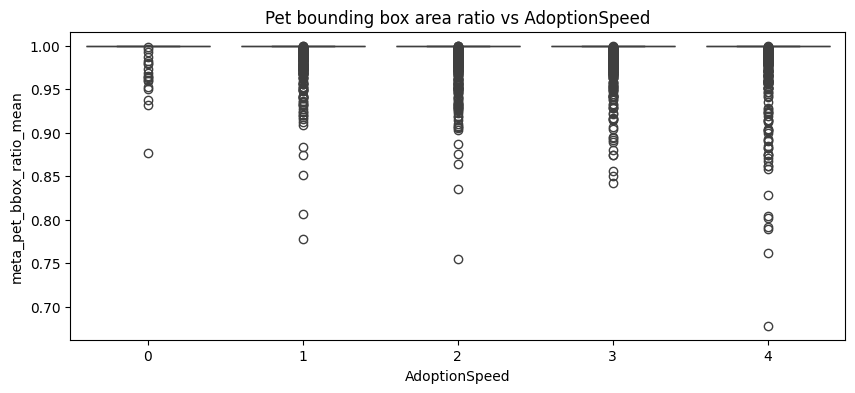

In [54]:
# Pet size in frame vs adoption speed

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
sns.boxplot(
    data=meta_merged_df,
    x="AdoptionSpeed",
    y="meta_pet_bbox_ratio_mean"
)
plt.title("Pet bounding box area ratio vs AdoptionSpeed")
plt.show()

We attempted to approximate pet size in the image using Google Vision’s crop hints. However, these bounding regions typically span nearly the entire frame due to Google’s aesthetic cropping objective. As a result, the bounding-box area ratio remains close to 1.0 for almost all pets, showing no meaningful variation across adoption speed classes. This feature was therefore excluded from further modeling.

In [55]:
flag_cols = ["has_outdoor", "has_indoor", "has_cage", "has_person", "has_sofa", "has_leash"]

flag_by_speed = (
    meta_merged_df
    .groupby("AdoptionSpeed")[flag_cols]
    .mean()
    .round(3)
)

flag_by_speed

,has_outdoor,has_indoor,has_cage,has_person,has_sofa,has_leash
AdoptionSpeed,,,,,,
0,0.020725,0.044041,0.03886,0.056995,0.0,0.0
1,0.034031,0.042539,0.037958,0.072317,0.000654,0.000327
2,0.037241,0.043989,0.042489,0.065984,0.00125,0.00025
3,0.044651,0.049302,0.053643,0.064186,0.002171,0.0
4,0.043675,0.048695,0.041416,0.050452,0.001004,0.000502


In [61]:
OUTPUT_DIR = "./processed"
os.makedirs(OUTPUT_DIR, exist_ok=True)

meta_pet_path = os.path.join(OUTPUT_DIR, "image_metadata_per_pet.csv")
meta_pet_df.to_csv(meta_pet_path, index=False)
print("Saved per-pet image metadata features to:", meta_pet_path)

Saved per-pet image metadata features to: ./processed/image_metadata_per_pet.csv


## EXTRA ANALYSIS FOR HAS_INDOOR AND HAS_CAGE

In [76]:
df = meta_merged_df.copy()

df["is_fast"] = df["AdoptionSpeed"].isin([0,1]).astype(int)
df["is_slow"] = df["AdoptionSpeed"].isin([3,4]).astype(int)

# Handle NaNs for all flags
for col in ["has_outdoor", "has_indoor", "has_cage"]:
    if col not in df.columns:
        df[col] = 0
    df[col] = df[col].fillna(0).astype(int)

In [77]:
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def analyze_flag(df, flag_col, verbose=True):
    # Raw counts
    a = ((df[flag_col] == 1) & (df["is_fast"] == 1)).sum()
    b = ((df[flag_col] == 1) & (df["is_slow"] == 1)).sum()
    c = ((df[flag_col] == 0) & (df["is_fast"] == 1)).sum()
    d = ((df[flag_col] == 0) & (df["is_slow"] == 1)).sum()

    # Haldane–Anscombe correction
    if a == 0: a += 0.5
    if b == 0: b += 0.5
    if c == 0: c += 0.5
    if d == 0: d += 0.5

    # Odds Ratio
    OR = (a / c) / (b / d)

    # Confidence Interval
    SE = math.sqrt(1/a + 1/b + 1/c + 1/d)
    lower = math.exp(math.log(OR) - 1.96 * SE)
    upper = math.exp(math.log(OR) + 1.96 * SE)

    # Chi-square test
    table = pd.crosstab(df[flag_col], df["AdoptionSpeed"])
    chi2, p_value, _, _ = chi2_contingency(table)

    # Plot
    fast_rate = a / (a + c)
    slow_rate = b / (b + d)

    plt.bar(["Fast adoptions", "Slow adoptions"], [fast_rate, slow_rate])
    plt.ylabel(f"Proportion of '{flag_col}'")
    plt.title(f"{flag_col} vs Adoption Outcome")
    plt.show()

    if verbose:
        print(f"=== {flag_col.upper()} Analysis ===")
        print(f"Odds Ratio = {OR:.3f} (95% CI: {lower:.3f}, {upper:.3f})")
        print(f"Chi-square p-value = {p_value:.4f}")
        print("------------------------------")

    return OR, (lower, upper), p_value

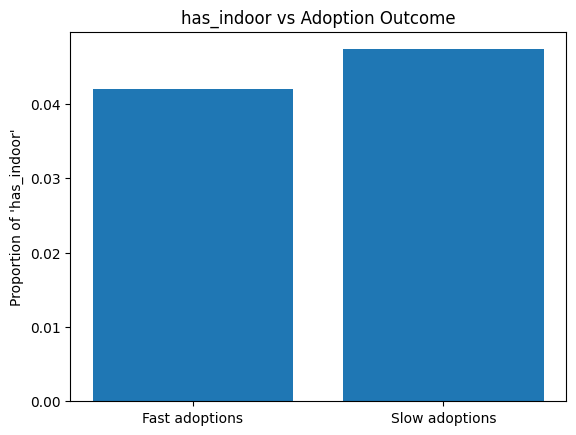

=== HAS_INDOOR Analysis ===
Odds Ratio = 0.882 (95% CI: 0.725, 1.074)
Chi-square p-value = 0.7084
------------------------------


(0.8821671683807745,
 (0.724623180914047, 1.0739635902722577),
 0.7084262773340163)

In [78]:
analyze_flag(df, "has_indoor")

Interpretation

- The proportion of indoor images is slightly higher in slow adoptions than fast ones.

- But the confidence interval includes 1, meaning the effect is not statistically different from “no effect”.

- The p-value (0.708) indicates ZERO evidence of a relationship.

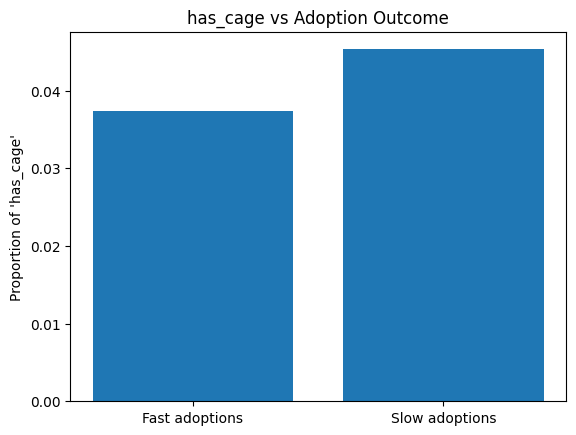

=== HAS_CAGE Analysis ===
Odds Ratio = 0.819 (95% CI: 0.667, 1.006)
Chi-square p-value = 0.0158
------------------------------


(0.8188636032323957,
 (0.6665237114934444, 1.0060221251488628),
 0.01582219497847947)

In [79]:
analyze_flag(df, "has_cage")

Interpretation

- Pets photographed in a cage are 18% less likely to be in the fast adoption group.

- The CI barely touches 1.0, meaning the effect is right on the edge of significance — but the p-value supports significance.

- The proportion of cage images is higher for slow adoptions (your chart shows this visually).

Pets shown inside cages/crates tend to be adopted more slowly, consistent with expectations that restrictive environments reduce visual appeal.

## CLIP Embeddings

In [82]:
# clip_semantics_config.py

ATTRIBUTE_PROMPTS = {
    "environment": {
        "env_indoor": "a pet in an indoor room",
        "env_outdoor": "a pet outdoors",
        "env_grass": "a pet outside on green grass",
        "env_cage": "a pet inside a cage",
        "env_kennel": "a pet in a kennel or crate",
        "env_blank_background": "a pet in front of a plain studio background",
    },
    "pose": {
        "pose_sitting": "a pet sitting",
        "pose_standing": "a pet standing",
        "pose_lying": "a pet lying down",
        "pose_closeup_face": "a close-up photo of a pet’s face",
        "pose_full_body": "a full body photo of a pet",
        "pose_multiple_pets": "a photo with multiple pets",
    },
    "size_framing": {
        "size_small_pet": "a small pet like a puppy or kitten",
        "size_large_pet": "a large dog",
        "frame_centered": "a pet centered in the frame",
        "frame_off_center": "a pet near the edge of the frame",
    },
    "sentiment": {
        "sent_happy_playful": "a happy, playful pet",
        "sent_relaxed_calm": "a relaxed, calm pet",
        "sent_neutral": "a neutral expression pet",
        "sent_scared_anxious": "a scared, anxious pet",
        "sent_sad_tired": "a sad or tired pet",
    },
    "human": {
        "human_present": "a pet with a person in the photo",
        "human_holding_pet": "a person holding a pet",
        "human_hand_only": "a pet with only a person’s hand visible",
    },
    "background": {
        "bg_clean_simple": "a pet in front of a clean, simple background",
        "bg_cluttered": "a pet with a cluttered messy background",
        "bg_homey": "a pet in a cozy home interior",
        "bg_outdoor_nature": "a pet in a natural outdoor environment",
    },
    "color": {
        "color_bright_colorful": "a bright, colorful pet photo",
        "color_dark": "a dark low-light pet photo",
        "color_warm": "a pet photo with warm colors",
        "color_cool": "a pet photo with cool colors",
        "color_bw": "a black and white pet photo",
    },
}

## Create a full per-pet image feature CSV

In [84]:
import os
import numpy as np
import pandas as pd

OUTPUT_DIR = "processed"  

# 1. Load the arrays you already saved
X_img        = np.load(os.path.join(OUTPUT_DIR, "X_img_embeddings.npy"))
X_img_aug    = np.load(os.path.join(OUTPUT_DIR, "X_img_embeddings_aug.npy"))
y_img        = np.load(os.path.join(OUTPUT_DIR, "y_adoption_speed.npy"))

# 2. Get the PetID order used for these embeddings
#    Use the same DataFrame you used when building X_img / X_img_aug
pet_ids = img_df["PetID"].astype(str).values   y

np.save(os.path.join(OUTPUT_DIR, "pet_ids_img.npy"), pet_ids)

# 3. Build a DataFrame from X_img_aug
n, d_aug = X_img_aug.shape
d_emb    = X_img.shape[1]
d_extra  = d_aug - d_emb   

embed_cols = [f"img_emb_{i}" for i in range(d_emb)]
extra_cols = [f"img_extra_{i}" for i in range(d_extra)] 
all_cols   = embed_cols + extra_cols

img_aug_df = pd.DataFrame(X_img_aug, columns=all_cols)
img_aug_df.insert(0, "PetID", pet_ids)

print("img_aug_df shape:", img_aug_df.shape)
img_aug_df.head()

img_aug_df shape: (14652, 1284)


,PetID,img_emb_0,img_emb_1,img_emb_2,img_emb_3,img_emb_4,img_emb_5,img_emb_6,img_emb_7,img_emb_8,...,img_emb_1273,img_emb_1274,img_emb_1275,img_emb_1276,img_emb_1277,img_emb_1278,img_emb_1279,img_extra_0,img_extra_1,img_extra_2
0,86e1089a3,0.253315,-0.147033,-0.159378,-0.063343,0.088517,0.035912,0.280325,0.279206,0.188644,...,-0.136594,0.112785,0.083095,-0.089407,0.220778,-0.055448,0.333759,95.860984,16.616995,672.776551
1,6296e909a,0.099347,-0.073799,0.547016,-0.163702,0.150605,-0.128184,0.206928,-0.141180,-0.115330,...,-0.087675,-0.005474,0.423294,-0.059712,0.219841,0.051374,0.000132,88.262347,50.059973,453.839186
2,3422e4906,0.101447,-0.063293,-0.093635,0.224517,-0.098054,-0.013184,-0.095741,0.023799,-0.069959,...,0.649306,0.169462,0.267310,1.148312,-0.097708,-0.162029,-0.073036,170.645100,11.606312,60.519822
3,5842f1ff5,0.117383,-0.104424,-0.061240,0.065842,0.007137,-0.076127,0.353393,0.133003,-0.037858,...,0.426876,0.130353,0.167361,-0.129700,0.855895,-0.047542,-0.136626,78.406617,76.517158,512.140914
4,850a43f90,0.156996,-0.096605,0.037499,-0.121142,-0.008129,-0.038452,-0.108121,0.130875,-0.200230,...,0.164303,0.344191,0.431245,0.458547,0.213458,-0.049097,0.111202,165.758596,47.471541,363.798839


In [85]:
# 4. Load per-pet Vision metadata
meta_path = os.path.join(OUTPUT_DIR, "image_metadata_per_pet.csv")  # adjust if needed
meta_df = pd.read_csv(meta_path)
meta_df["PetID"] = meta_df["PetID"].astype(str)

print("meta_df shape:", meta_df.shape)

# 5. Merge metadata + embeddings + quality
img_full_df = meta_df.merge(img_aug_df, on="PetID", how="left")

print("img_full_df shape:", img_full_df.shape)
img_full_df.head()

# 6. Save for use in the fusion notebook
full_path = os.path.join(OUTPUT_DIR, "image_all_features_per_pet.csv")
img_full_df.to_csv(full_path, index=False)
print("Saved:", full_path)

meta_df shape: (14652, 13)
img_full_df shape: (14652, 1296)
Saved: processed/image_all_features_per_pet.csv
